In [13]:
import io
import os
import requests
import datetime
import warnings
import winsound
import itertools
import matplotlib
import statistics 
import numpy as np
import pandas as pd
from numpy import zeros
from pathlib import Path
from pylab import rcParams
import statsmodels.api as sm
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style 
from bokeh.plotting import figure, show, output_file
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
print('TimeFrames : H1, H4, D1, W1, MN')
timeframe01=input('Enter The TimeFrame :',)
timeframe1=str(timeframe01).upper()
direction1=str("C:\\Users\\maryam\\Documents")
currencies0 = os.listdir(direction1)    
currencies = list(filter(lambda f: f.endswith('.csv'), currencies0))
numcurrencies=len(currencies)
print(Fore.BLACK +'---------------------------List of All Currencies----------------------------')
print(Fore.BLACK +'The Number of Total Currencies is :'+' ' ,numcurrencies)
currencies

TimeFrames : H1, H4, D1, W1, MN
Enter The TimeFrame :1h
---------------------------List of All Currencies----------------------------
The Number of Total Currencies is :  4


['BTCUSD.csv', 'indice.csv', 'XAUUSD,H1.csv', 'XAUUSD.csv']

In [15]:
#DIRECTION AND SELECT CURRENCY-------------------------------------------------------------------------------------------
namestart0=input('Whats The Name of Currency ? ').upper()
namestart1=namestart0+('.csv')
def find_files(filename, search_path):
    result = []

    for root, dir, files in os.walk(search_path):
        if filename in files:
            result.append(os.path.join(root, filename))
    return result
filepath1=find_files(namestart1,direction1)
print('------------------------The file'+' '+namestart1+' '+'is in this directory---------------------')
print(filepath1[0])

Whats The Name of Currency ? XAUUSD,H1
------------------------The file XAUUSD,H1.csv is in this directory---------------------
C:\Users\maryam\Documents\XAUUSD,H1.csv


In [16]:
indice0Close=pd.read_csv(filepath1[0],usecols=[0,5,6])
daynumber=indice0Close.shape[0]
today=datetime.datetime(datetime.datetime.now().year,
                         datetime.datetime.now().month,
                         datetime.datetime.now().day)
#-------------------------------------------------------------------------------------------------------
daynumber=indice0Close.shape[0]
indice0Close['Date']= pd.DataFrame(pd.date_range(end=today, periods=daynumber, freq='D'))
#DEFINE START-------------------------------------------------------------------------------------------
print(Fore.BLACK +'Days of total data :',indice0Close.shape[0])
start0test=input('Enter the start date for choose the Currency : ')
starttest=int(start0test)
#-------------------------------------------------------------------------------------------------------
dataset=pd.DataFrame(data=indice0Close.values[starttest:daynumber,:],columns=['Date','Close','Volume'])
dataset

Days of total data : 2048
Enter the start date for choose the Currency : 1000


,Date,Close,Volume
0,2019-01-21,1756.61,4242
1,2019-01-22,1755.68,3745
2,2019-01-23,1757.0,1727
3,2019-01-24,1755.26,1126
4,2019-01-25,1752.93,1635
...,...,...,...
1043,2021-11-29,1771.7,4020
1044,2021-11-30,1774.03,4329
1045,2021-12-01,1769.83,14118
1046,2021-12-02,1770.7,13583


# Best Moving Averages

In [17]:
#Sharp Ratio Function---------------------------------------------------------------------------------------------
def annualised_sharpe(returns, N=252):
    try:
        return np.sqrt(N) * (returns.mean() / returns.std())
    except ZeroDivisionError:
        return 0
#Best Moving Function---------------------------------------------------------------------------------------------
def best_ma(short_ma,long_ma):
    dataset_best_ma=dataset
    dataset_best_ma['short_ma']=dataset['Close'].rolling(window=short_ma).mean()
    dataset_best_ma['long_ma']=dataset['Close'].rolling(window=long_ma).mean()
    dataset_best_ma['short-long']=dataset_best_ma['short_ma']-dataset_best_ma['long_ma']
    x_best=0
    #BUY
    dataset_best_ma['Position']=np.where((dataset_best_ma['short-long']>x_best) &
                                         (dataset_best_ma['Close']>dataset_best_ma['short_ma']),1,0)
    #SELL
    dataset_best_ma['Position']=np.where((dataset_best_ma['short-long']<x_best) &
                                         (dataset_best_ma['Close']<dataset_best_ma['short_ma']),
                                         -1,dataset_best_ma['Position'])
    dataset_best_ma['Returns']=(dataset['Close'])/(dataset['Close'].shift(1))
    dataset_best_ma['Market Returns']=np.log(dataset_best_ma['Returns'].astype('float64'))*100
    dataset_best_ma['Strategy Profit']=dataset_best_ma['Market Returns']*dataset_best_ma['Position'].shift(1)
    dataset_best_ma['Strategy Equity']=dataset_best_ma['Strategy Profit'].cumsum()+1
    sharpe=annualised_sharpe(dataset_best_ma['Strategy Profit'])
    
    return (dataset_best_ma['Strategy Profit'].cumsum().iloc[-1],sharpe)
#Periods of Movings------------------------------------------------------------------------------------------------
from itertools import combinations
periods=np.linspace(5,105,100,dtype=int)
periods_list=list(combinations(periods,2))
list_of_ma=[]
for i,j in enumerate(periods_list):
    list_of_ma.append(best_ma(j[0],j[1]))
final_ma=pd.DataFrame(data=list_of_ma,columns=['Strategy Profit','Sharpe'],
                      index=periods_list).sort_values('Sharpe',ascending=False)
final_ma

,Strategy Profit,Sharpe
"(43, 47)",5.250462,0.549073
"(41, 86)",5.003413,0.540575
"(78, 101)",4.859742,0.508183
"(36, 91)",4.461153,0.498909
"(42, 86)",4.603469,0.498891
...,...,...
"(56, 71)",-4.436470,-0.486260
"(56, 70)",-4.566185,-0.498065
"(58, 72)",-4.612081,-0.504516
"(58, 73)",-4.629151,-0.507360


In [18]:
dataset.tail()

,Date,Close,Volume,short_ma,long_ma,short-long,Position,Returns,Market Returns,Strategy Profit,Strategy Equity
1043,2021-11-29,1771.7,4020,1781.710680,1781.951333,-0.240654,-1,1.000904,0.090350,-0.090350,-0.383178
1044,2021-11-30,1774.03,4329,1781.506990,1781.749524,-0.242534,-1,1.001315,0.131426,-0.131426,-0.514604
1045,2021-12-01,1769.83,14118,1781.262136,1781.524381,-0.262245,-1,0.997633,-0.237030,0.237030,-0.277574
1046,2021-12-02,1770.7,13583,1781.034757,1781.292857,-0.258100,-1,1.000492,0.049145,-0.049145,-0.326719
1047,2021-12-03,1770.62,4634,1780.820485,1781.060190,-0.239705,-1,0.999955,-0.004518,0.004518,-0.322201


Enter the SHORT MA for Close Price : 43
Enter the LONG MA for Close Price : 47


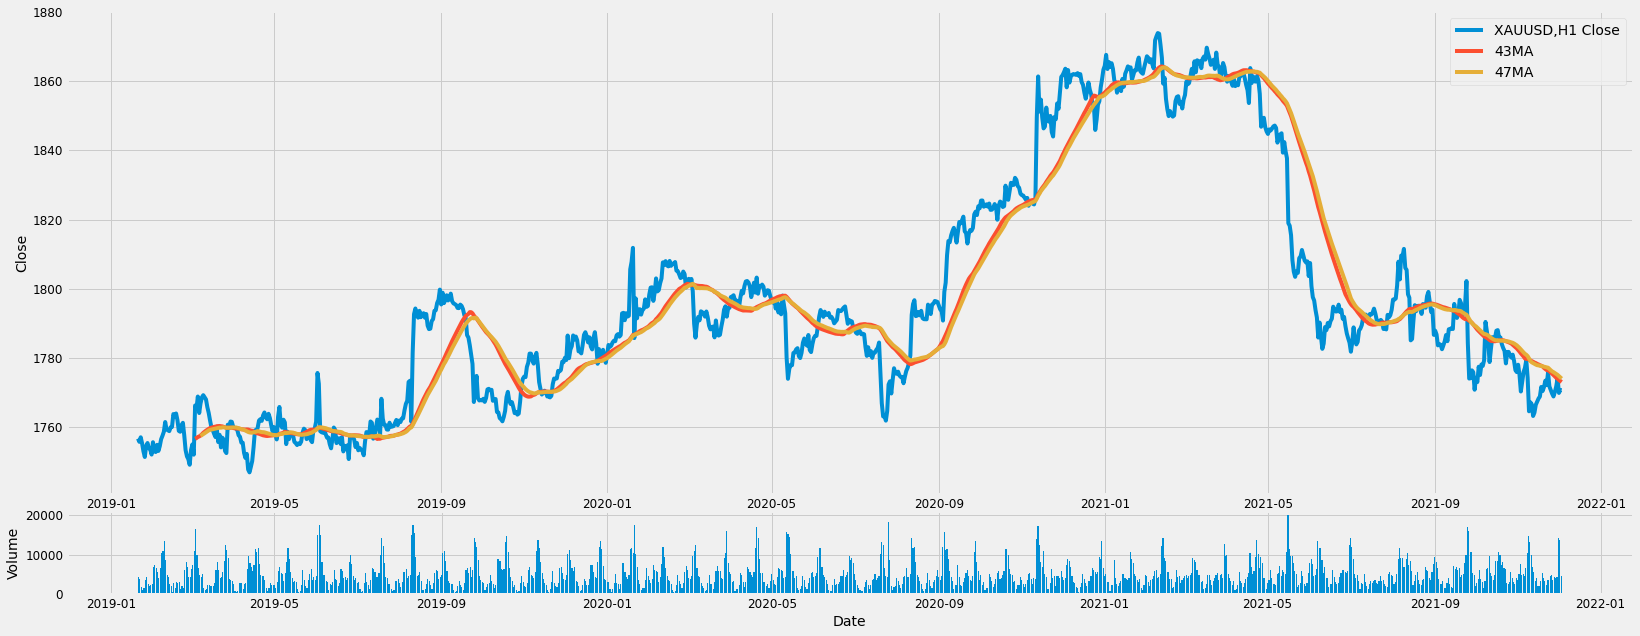

In [19]:
#Moving Averages-------------------------------------------------------------
moving1=int(input('Enter the SHORT MA for Close Price : '))
moving2=int(input('Enter the LONG MA for Close Price : '))
#-----------------------------------------------------------------------------
dataset_moving1=dataset.join(pd.Series(moving1,name=str(moving1)+'MA'))
dataset_moving2=dataset.join(pd.Series(moving2,name=str(moving2)+'MA'))
#-----------------------------------------------------------------------------
dataset_moving1[str(moving1)+'MA']=dataset['Close'].rolling(window=moving1).mean()
dataset_moving2[str(moving2)+'MA']=dataset['Close'].rolling(window=moving2).mean()
dataset_movings=dataset_moving1.join(dataset_moving2[str(moving2)+'MA'])
#plotting movings-------------------------------------------------------------
rcParams['figure.figsize']=25,10
ax1=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax2=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=3)
ax1.plot(dataset['Date'],dataset_movings['Close'], label=namestart0+' '+'Close')
ax1.plot(dataset['Date'],dataset_movings[str(moving1)+'MA'], label=str(moving1)+'MA')
ax1.plot(dataset['Date'],dataset_movings[str(moving2)+'MA'], label=str(moving2)+'MA')
ax1.legend(loc='best')
ax2.bar(dataset['Date'],dataset['Volume'], label='Volume')
ax2.set_xlabel('Date')
ax1.set_ylabel('Close')
ax2.set_ylabel('Volume')
plt.show()

# Strategy based on Moving Averages

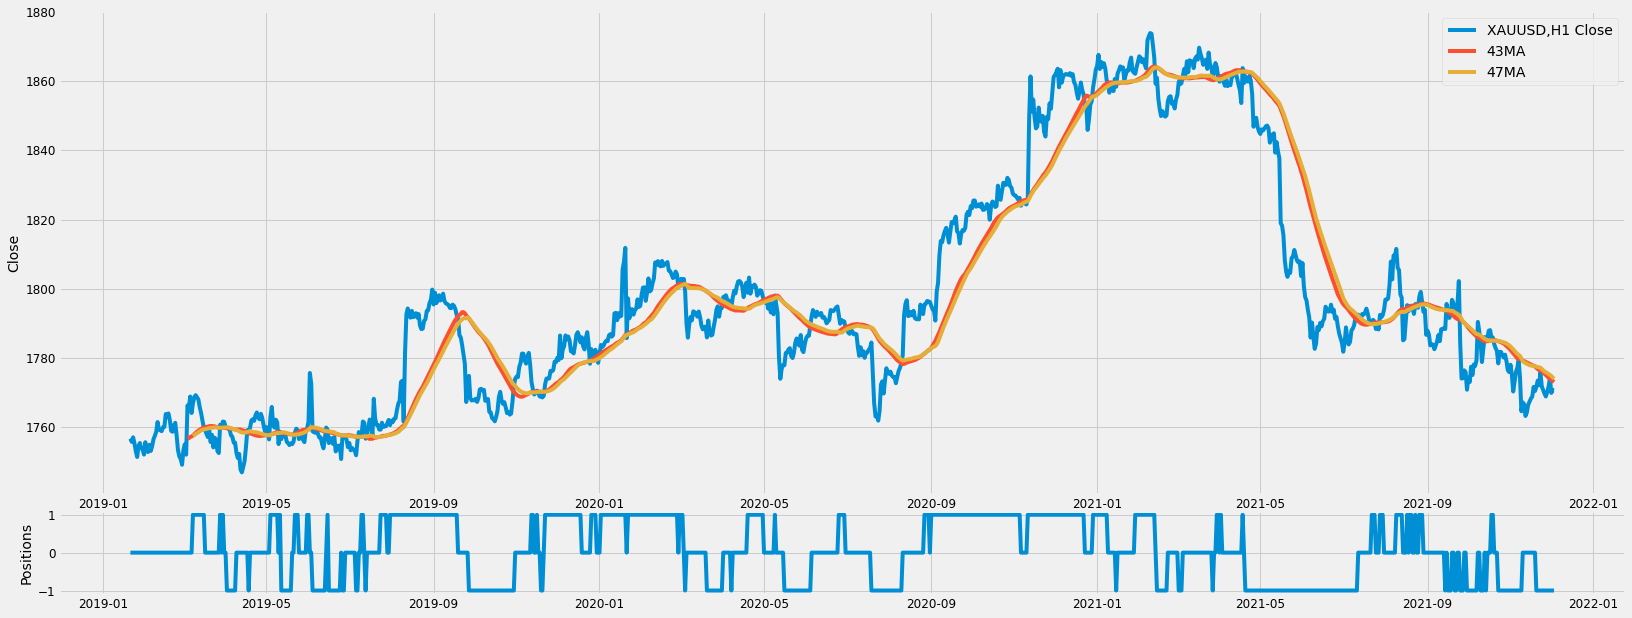

In [20]:
#Strategy 2 based on MA Differences-------------------------------------------------------------
dataset_movings[str(moving1)+'-'+str(moving2)]=dataset_movings[str(moving1)+'MA']-dataset_movings[str(moving2)+'MA']
x2=0 #thershold----------------------------------------------------------------------------------
#BUY
dataset_movings['Position']=np.where((dataset_movings[str(moving1)+'-'+str(moving2)]>x2) &
                                     (dataset_movings['Close']>dataset_movings[str(moving1)+'MA']),1,0)
#SELL
dataset_movings['Position']=np.where((dataset_movings[str(moving1)+'-'+str(moving2)]<x2) &
                                     (dataset_movings['Close']<dataset_movings[str(moving2)+'MA']),-1,dataset_movings['Position'])
#Close Price Plotting---------------------------------------------------------------------------
rcParams['figure.figsize']=25,10
ax11=plt.subplot2grid((6,1),(0,0),rowspan=5,colspan=1)
ax12=plt.subplot2grid((6,1),(5,0),rowspan=1,colspan=3)
ax11.plot(dataset['Date'],dataset['Close'], label=namestart0+' '+'Close')
ax11.plot(dataset['Date'],dataset_movings[str(moving1)+'MA'], label=str(moving1)+'MA')
ax11.plot(dataset['Date'],dataset_movings[str(moving2)+'MA'], label=str(moving2)+'MA')
ax11.legend(loc='best')
ax11.set_ylabel('Close')
#position plotting-------------------------------------------------------------------------------
ax12.plot(dataset['Date'],dataset_movings['Position'])
ax12.set_ylabel('Positions')
plt.show()

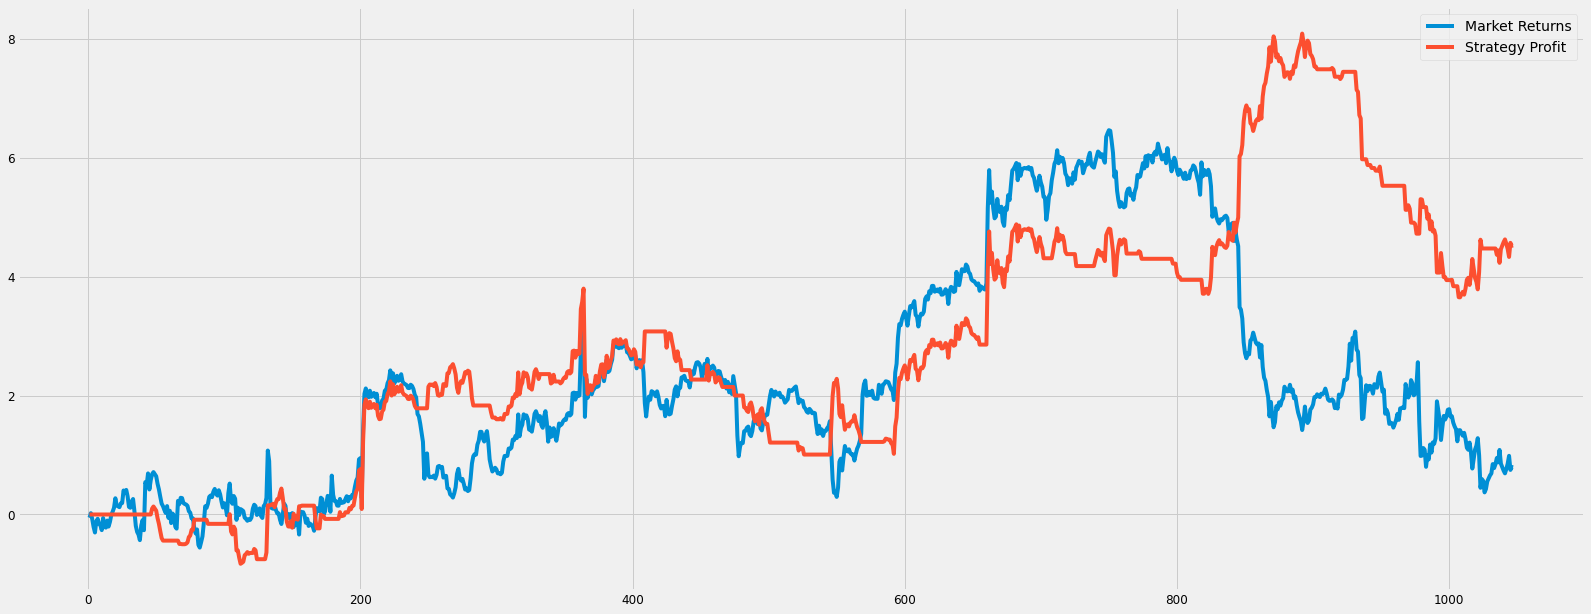

In [21]:
#plot strategy Movings------------------------------------------------------------------
dataset_movings['Returns']=(dataset['Close'])/(dataset['Close'].shift(1))
dataset_movings['Market Returns']=np.log(dataset_movings['Returns'].astype('float64'))*100
dataset_movings['Strategy Profit']=dataset_movings['Market Returns']*dataset_movings['Position'].shift(1)
dataset_movings[['Market Returns','Strategy Profit']].cumsum().plot(grid=True,figsize=(25,10))
plt.show()